In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot
%matplotlib inline

import librosa

import tensorflow as tf

/home/alberto/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
audio_path = "./data/audiodata"
labels_file = "./data/conflictlevel.csv"

intervals_seconds = 3
sample_rate = 8000

In [3]:
labels_df = pd.read_csv(labels_file, header=None)
labels_df.head()

,0,1
0,06-04-05_60_90,-7.9
1,06-04-05_240_270,-4.8
2,06-04-05_300_330,-3.7
3,06-04-05_330_360,-5.4
4,06-04-05_420_450,-5.8


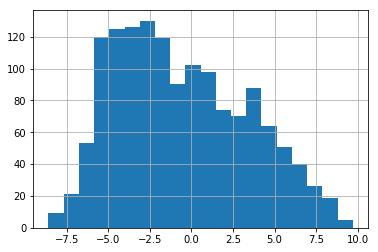

In [4]:
labels_df[1].hist(bins=20)

In [5]:
labels_df["class"] = labels_df[1].apply(lambda x: 0 if x < 0 else 1)

In [6]:
labels_df["class"].value_counts()

0    824
1    606
Name: class, dtype: int64

In [7]:
labels_df.shape

(1430, 3)

## Randomly separate files in Train, Test data validation data

In [8]:
def train_test_val_split(df, test_percentage, validation_percentage):
    """
    shuffles the data and divide the dataframe in train, test and validation dataframes
    according to the percentages given
    returns the 3 dataframes
    """
    
    indices = np.random.permutation(df.index)
    
    test_size = int(df.shape[0]*test_percentage)
    val_size = int(df.shape[0]*validation_percentage)
    
    test = df.iloc[indices[:test_size]]
    validation = df.iloc[indices[test_size:test_size+val_size]]
    train = df.iloc[indices[test_size+val_size:]]
    
    assert (test.shape[0]+validation.shape[0]+train.shape[0]) == df.shape[0]
    
    return train, test, validation

In [9]:
train_df, test_df, validation_df = train_test_val_split(labels_df, 0.2, 0.15)

In [10]:
train_df.to_csv("./data/train_files.csv", index=False)
test_df.to_csv("./data/test_files.csv", index=False)
validation_df.to_csv("./data/validation_files.csv", index=False)

## Prepare data for training (convert sample rate, divide files in N seconds intervals, create dataset)

In [11]:
def divide_audio_file(path, intervals_seconds, interval_step, sample_rate=8000):
    """

    """
    
    # loads file and converts to the specified sample rate    
    audio, fs = librosa.load(path, sample_rate)
    
    audio_array = []
    for i in range(0, audio.shape[0], interval_step):   
        interval = audio[i:i+sample_rate*intervals_seconds]
#         print("interval from {} to {}".format(i, i+sample_rate*intervals_seconds))
        
        # if the last interval is shorter han the interval in seconds we define we are going to ignore it
        if interval.shape[0] < sample_rate*intervals_seconds:
            break
        else:
            audio_array.append(interval)

    return np.array(audio_array)

In [12]:
def create_dataset(audio_path, file_names_df):
    
    x_data = []
    labels = []
    
    for file in os.listdir(audio_path):

        file_path = audio_path + "/" + file

        short_name = file.split(".")[0]

        # if the file is in the dataframe with the file names(train or test) we divide it, if not we ignore
        if short_name in file_names_df[0].values:
            print("reading file {}".format(file))

            divided_file =  divide_audio_file(file_path, intervals_seconds, sample_rate)

            file_label = file_names_df[file_names_df[0] == short_name]["class"].values[0]
            labels_array = np.ones(divided_file.shape[0]) * file_label
            print(labels_array)
            
            x_data.extend(divided_file)
            labels.extend(labels_array)
            
        else:
            print("file {} not in the dataframe".format(file))

    return np.array(x_data), np.array(labels)


In [13]:
def save_dataset(x_data, labels, filename):
    
    dataset = np.concatenate([x_data.reshape(-1,24000), labels.reshape(-1,1)], axis=1)
    
    np.save(filename, dataset)

# Work with tf records

In [14]:
def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [15]:
def convert_and_save_records(x_data, labels, save_path, tf_record_files):
    
    filename = '{}/{}_{}.tfrecords'.format(save_path, len(x_data), tf_record_files)
    writer = tf.python_io.TFRecordWriter(filename)

    for i, interval in enumerate(x_data):
        feature = {'sound':  _bytes_feature(tf.compat.as_bytes(interval.tostring())),
                   'label':  _float_feature(labels[i])}

        example = tf.train.Example(features=tf.train.Features(feature=feature))
        writer.write(example.SerializeToString())

    writer.close()
    

In [16]:
def create_tf_records(audio_path, file_names_df, save_path):
    
    x_data = []
    labels = []
    tf_record_files = 1  
    for file in os.listdir(audio_path):

        file_path = audio_path + "/" + file
        short_name = file.split(".")[0]

        # if the file is in the dataframe with the file names(train or test) we divide it, if not we ignore
        if short_name in file_names_df[0].values:
            print("reading file {}".format(file))

            divided_file =  divide_audio_file(file_path, intervals_seconds, sample_rate)

            file_label = file_names_df[file_names_df[0] == short_name]["class"].values[0]
            labels_array = np.ones(divided_file.shape[0]) * file_label
#             print(labels_array)
            
            x_data.extend(divided_file)
            labels.extend(labels_array)            
            
            # if we already have more than 2500 files dump them in a tf records file
            if len(x_data) > 2500:
                convert_and_save_records(x_data, labels, save_path, tf_record_files)
            
                x_data = []
                labels = []
                tf_record_files += 1
                        
        else:
            print("file {} not in the dataframe".format(file))
       
    #  for the final data
    if len(x_data) > 0:
        convert_and_save_records(x_data, labels, save_path, tf_record_files)
                
    return 0


In [18]:
create_tf_records(audio_path, train_df,"./data/tf_data/train" )

file 06-04-05_1020_1050.wav not in the dataframe
file 06-04-05_1050_1080.wav not in the dataframe
reading file 06-04-05_1110_1140.wav
file 06-04-05_1140_1170.wav not in the dataframe
reading file 06-04-05_1170_1200.wav
reading file 06-04-05_1200_1230.wav
reading file 06-04-05_1230_1260.wav
file 06-04-05_1320_1350.wav not in the dataframe
reading file 06-04-05_1380_1410.wav
reading file 06-04-05_1710_1740.wav
file 06-04-05_1800_1830.wav not in the dataframe
reading file 06-04-05_1950_1980.wav
reading file 06-04-05_1980_2010.wav
file 06-04-05_2070_2100.wav not in the dataframe
reading file 06-04-05_2100_2130.wav
file 06-04-05_2220_2250.wav not in the dataframe
file 06-04-05_2280_2310.wav not in the dataframe
file 06-04-05_2310_2340.wav not in the dataframe
reading file 06-04-05_2370_2400.wav
reading file 06-04-05_2400_2430.wav
reading file 06-04-05_240_270.wav
file 06-04-05_2430_2460.wav not in the dataframe
file 06-04-05_300_330.wav not in the dataframe
reading file 06-04-05_330_360.wav

0

In [19]:
create_tf_records(audio_path, validation_df,"./data/tf_data/validation" )

file 06-04-05_1020_1050.wav not in the dataframe
file 06-04-05_1050_1080.wav not in the dataframe
file 06-04-05_1110_1140.wav not in the dataframe
file 06-04-05_1140_1170.wav not in the dataframe
file 06-04-05_1170_1200.wav not in the dataframe
file 06-04-05_1200_1230.wav not in the dataframe
file 06-04-05_1230_1260.wav not in the dataframe
file 06-04-05_1320_1350.wav not in the dataframe
file 06-04-05_1380_1410.wav not in the dataframe
file 06-04-05_1710_1740.wav not in the dataframe
file 06-04-05_1800_1830.wav not in the dataframe
file 06-04-05_1950_1980.wav not in the dataframe
file 06-04-05_1980_2010.wav not in the dataframe
file 06-04-05_2070_2100.wav not in the dataframe
file 06-04-05_2100_2130.wav not in the dataframe
reading file 06-04-05_2220_2250.wav
reading file 06-04-05_2280_2310.wav
file 06-04-05_2310_2340.wav not in the dataframe
file 06-04-05_2370_2400.wav not in the dataframe
file 06-04-05_2400_2430.wav not in the dataframe
file 06-04-05_240_270.wav not in the dataframe

0

In [ ]:
# x, y = create_dataset(audio_path, train_df)

In [145]:
# save_dataset(x, y, "./data/train_dataset.npy")